# Tobacco Yield Prediction Model Training

This notebook trains a machine learning model to predict tobacco yield based on environmental sensor data.

**Note**: Since this is the first growing season with no historical yield data, we'll use optimal growing conditions research to generate simulated yield data for initial training. Replace this with actual yield measurements as you collect them.

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn joblib


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

: 

## 1. Load and Explore Data

In [5]:
# Load the sensor data
df = pd.read_csv('cropiot.sensor_data.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (493, 10)

Columns: ['_id', 'timestamp', 'sensor_id', 'soil_moisture', 'ph', 'temperature', 'humidity', 'rssi', 'snr', 'created_at']

First few rows:


,_id,timestamp,sensor_id,soil_moisture,ph,temperature,humidity,rssi,snr,created_at
0,6903c43f550f1cf2776b87ef,2025-10-30 00:00:00+00:00,Sensor_2,0,6.46,-999.0,-999.0,-76,9.00,2025-10-30T22:02:07.304Z
1,69088bfb0633c746f8a0905d,2025-10-30 00:00:00+00:00,Sensor_1,100,6.35,-999.0,-999.0,-55,9.75,2025-11-03T13:03:23.593Z
2,69088c370633c746f8a0905e,2025-10-30 00:12:00+00:00,Sensor_2,100,6.20,-999.0,-999.0,-56,10.50,2025-11-03T13:04:23.723Z
3,69088c730633c746f8a0905f,2025-10-30 00:24:00+00:00,Sensor_2,100,5.93,-999.0,-999.0,-56,10.75,2025-11-03T13:05:23.837Z
4,69088cae0633c746f8a09060,2025-10-30 00:05:00+00:00,Sensor_1,100,6.07,31.8,66.1,-56,9.75,2025-11-03T13:06:22.307Z


In [6]:
# Data info and missing values
print("Data Info:")
print(df.info())
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nBasic statistics:\n{df.describe()}")

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493 entries, 0 to 492
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   _id            493 non-null    object 
 1   timestamp      493 non-null    object 
 2   sensor_id      493 non-null    object 
 3   soil_moisture  493 non-null    int64  
 4   ph             493 non-null    float64
 5   temperature    493 non-null    float64
 6   humidity       493 non-null    float64
 7   rssi           493 non-null    int64  
 8   snr            493 non-null    float64
 9   created_at     493 non-null    object 
dtypes: float64(4), int64(2), object(4)
memory usage: 38.6+ KB
None

Missing values:
_id              0
timestamp        0
sensor_id        0
soil_moisture    0
ph               0
temperature      0
humidity         0
rssi             0
snr              0
created_at       0
dtype: int64

Basic statistics:
       soil_moisture          ph  temperature    

## 2. Data Preprocessing

In [7]:
# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['created_at'] = pd.to_datetime(df['created_at'])

# Replace -999.0 (sensor error values) with NaN
df.replace(-999.0, np.nan, inplace=True)

# Drop rows with missing temperature or humidity (critical for yield)
df_clean = df.dropna(subset=['temperature', 'humidity']).copy()

# Fill missing pH and soil_moisture with sensor-specific median
for sensor in df_clean['sensor_id'].unique():
    mask = df_clean['sensor_id'] == sensor
    df_clean.loc[mask, 'ph'] = df_clean.loc[mask, 'ph'].fillna(df_clean.loc[mask, 'ph'].median())
    df_clean.loc[mask, 'soil_moisture'] = df_clean.loc[mask, 'soil_moisture'].fillna(df_clean.loc[mask, 'soil_moisture'].median())

print(f"Clean dataset shape: {df_clean.shape}")
print(f"Removed {len(df) - len(df_clean)} rows with critical missing values")

Clean dataset shape: (487, 10)
Removed 6 rows with critical missing values


## 3. Feature Engineering

In [8]:
# Extract time-based features
df_clean['hour'] = df_clean['timestamp'].dt.hour
df_clean['day_of_week'] = df_clean['timestamp'].dt.dayofweek
df_clean['day_of_year'] = df_clean['timestamp'].dt.dayofyear

# Create rolling averages for environmental stability
for sensor in df_clean['sensor_id'].unique():
    mask = df_clean['sensor_id'] == sensor
    sensor_data = df_clean[mask].sort_values('timestamp')
    
    # 24-hour rolling averages
    df_clean.loc[mask, 'temp_rolling_24h'] = sensor_data['temperature'].rolling(window=24, min_periods=1).mean().values
    df_clean.loc[mask, 'humidity_rolling_24h'] = sensor_data['humidity'].rolling(window=24, min_periods=1).mean().values
    df_clean.loc[mask, 'soil_moisture_rolling_24h'] = sensor_data['soil_moisture'].rolling(window=24, min_periods=1).mean().values
    
    # Standard deviation (measure of stability)
    df_clean.loc[mask, 'temp_std_24h'] = sensor_data['temperature'].rolling(window=24, min_periods=1).std().fillna(0).values
    df_clean.loc[mask, 'humidity_std_24h'] = sensor_data['humidity'].rolling(window=24, min_periods=1).std().fillna(0).values

# Vapor Pressure Deficit (VPD) - important for plant growth
df_clean['vpd'] = 0.611 * np.exp((17.502 * df_clean['temperature']) / (df_clean['temperature'] + 240.97)) * (1 - df_clean['humidity'] / 100)

print(f"Features after engineering: {df_clean.columns.tolist()}")

Features after engineering: ['_id', 'timestamp', 'sensor_id', 'soil_moisture', 'ph', 'temperature', 'humidity', 'rssi', 'snr', 'created_at', 'hour', 'day_of_week', 'day_of_year', 'temp_rolling_24h', 'humidity_rolling_24h', 'soil_moisture_rolling_24h', 'temp_std_24h', 'humidity_std_24h', 'vpd']


## 4. Generate Simulated Yield Data

**Optimal Tobacco Growing Conditions (Zimbabwe):**
- Temperature: 20-30°C (optimal: 25°C)
- Humidity: 40-70% (optimal: 55%)
- Soil Moisture: 60-80% (optimal: 70%)
- pH: 5.5-6.5 (optimal: 6.0)
- VPD: 0.8-1.2 kPa (optimal: 1.0)

Expected yield range: 1,500 - 3,500 kg/hectare

In [9]:
def calculate_yield_score(row):
    """
    Calculate a yield score (0-1) based on how close conditions are to optimal.
    This simulates yield based on agricultural research.
    """
    # Temperature score (optimal: 25°C, range: 20-30°C)
    temp_optimal = 25
    temp_score = 1 - min(abs(row['temp_rolling_24h'] - temp_optimal) / 15, 1)
    
    # Humidity score (optimal: 55%, range: 40-70%)
    humidity_optimal = 55
    humidity_score = 1 - min(abs(row['humidity_rolling_24h'] - humidity_optimal) / 30, 1)
    
    # Soil moisture score (optimal: 70%, range: 60-80%)
    moisture_optimal = 70
    moisture_score = 1 - min(abs(row['soil_moisture_rolling_24h'] - moisture_optimal) / 30, 1)
    
    # pH score (optimal: 6.0, range: 5.5-6.5)
    ph_optimal = 6.0
    ph_score = 1 - min(abs(row['ph'] - ph_optimal) / 1.0, 1)
    
    # VPD score (optimal: 1.0, range: 0.8-1.2)
    vpd_optimal = 1.0
    vpd_score = 1 - min(abs(row['vpd'] - vpd_optimal) / 0.5, 1)
    
    # Stability penalty (high variance = stress = lower yield)
    stability_penalty = 1 - min((row['temp_std_24h'] / 10 + row['humidity_std_24h'] / 20) / 2, 0.3)
    
    # Weighted combination (temperature and moisture are most critical)
    weights = {
        'temp': 0.25,
        'humidity': 0.20,
        'moisture': 0.25,
        'ph': 0.15,
        'vpd': 0.15
    }
    
    total_score = (
        temp_score * weights['temp'] +
        humidity_score * weights['humidity'] +
        moisture_score * weights['moisture'] +
        ph_score * weights['ph'] +
        vpd_score * weights['vpd']
    ) * stability_penalty
    
    return total_score

# Calculate yield scores
df_clean['yield_score'] = df_clean.apply(calculate_yield_score, axis=1)

# Convert to kg/hectare (1,500 - 3,500 range)
min_yield = 1500
max_yield = 3500
df_clean['yield_kg_per_ha'] = min_yield + (df_clean['yield_score'] * (max_yield - min_yield))

# Add some realistic noise (±10%)
np.random.seed(42)
noise = np.random.normal(0, 0.1, len(df_clean))
df_clean['yield_kg_per_ha'] = df_clean['yield_kg_per_ha'] * (1 + noise)
df_clean['yield_kg_per_ha'] = df_clean['yield_kg_per_ha'].clip(min_yield, max_yield)

print(f"\nYield statistics:")
print(df_clean['yield_kg_per_ha'].describe())


Yield statistics:
count     487.000000
mean     2398.673772
std       297.388819
min      1655.230525
25%      2209.484947
50%      2407.488578
75%      2607.000652
max      3210.751827
Name: yield_kg_per_ha, dtype: float64


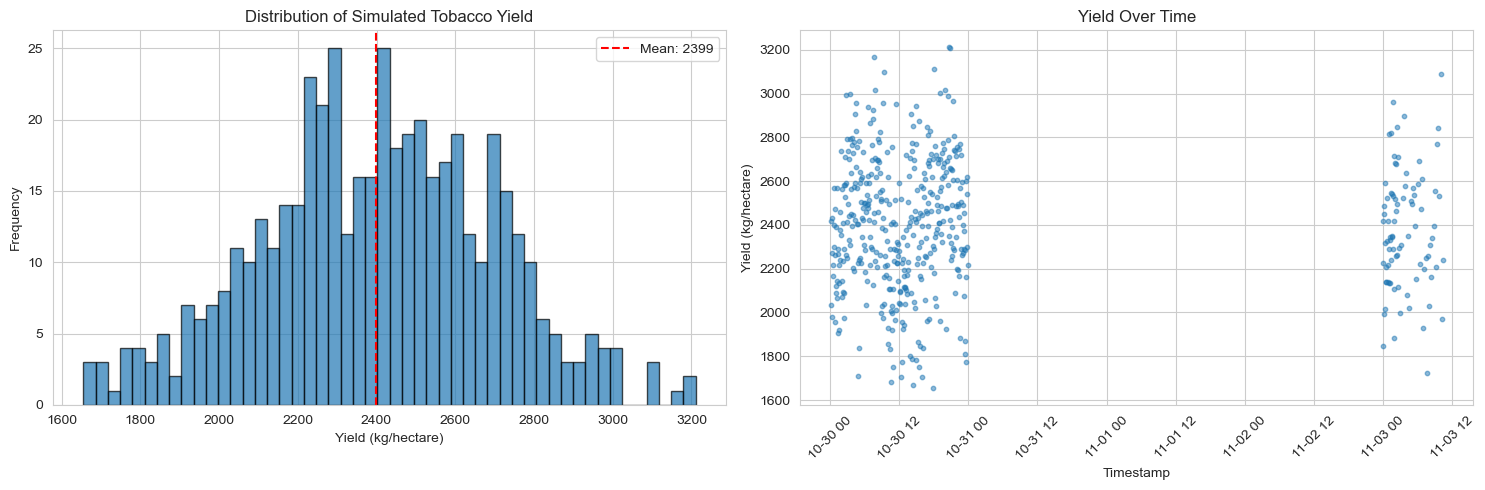

In [10]:
# Visualize yield distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(df_clean['yield_kg_per_ha'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Yield (kg/hectare)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Simulated Tobacco Yield')
axes[0].axvline(df_clean['yield_kg_per_ha'].mean(), color='red', linestyle='--', label=f'Mean: {df_clean["yield_kg_per_ha"].mean():.0f}')
axes[0].legend()

# Yield over time
axes[1].scatter(df_clean['timestamp'], df_clean['yield_kg_per_ha'], alpha=0.5, s=10)
axes[1].set_xlabel('Timestamp')
axes[1].set_ylabel('Yield (kg/hectare)')
axes[1].set_title('Yield Over Time')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 5. Correlation Analysis

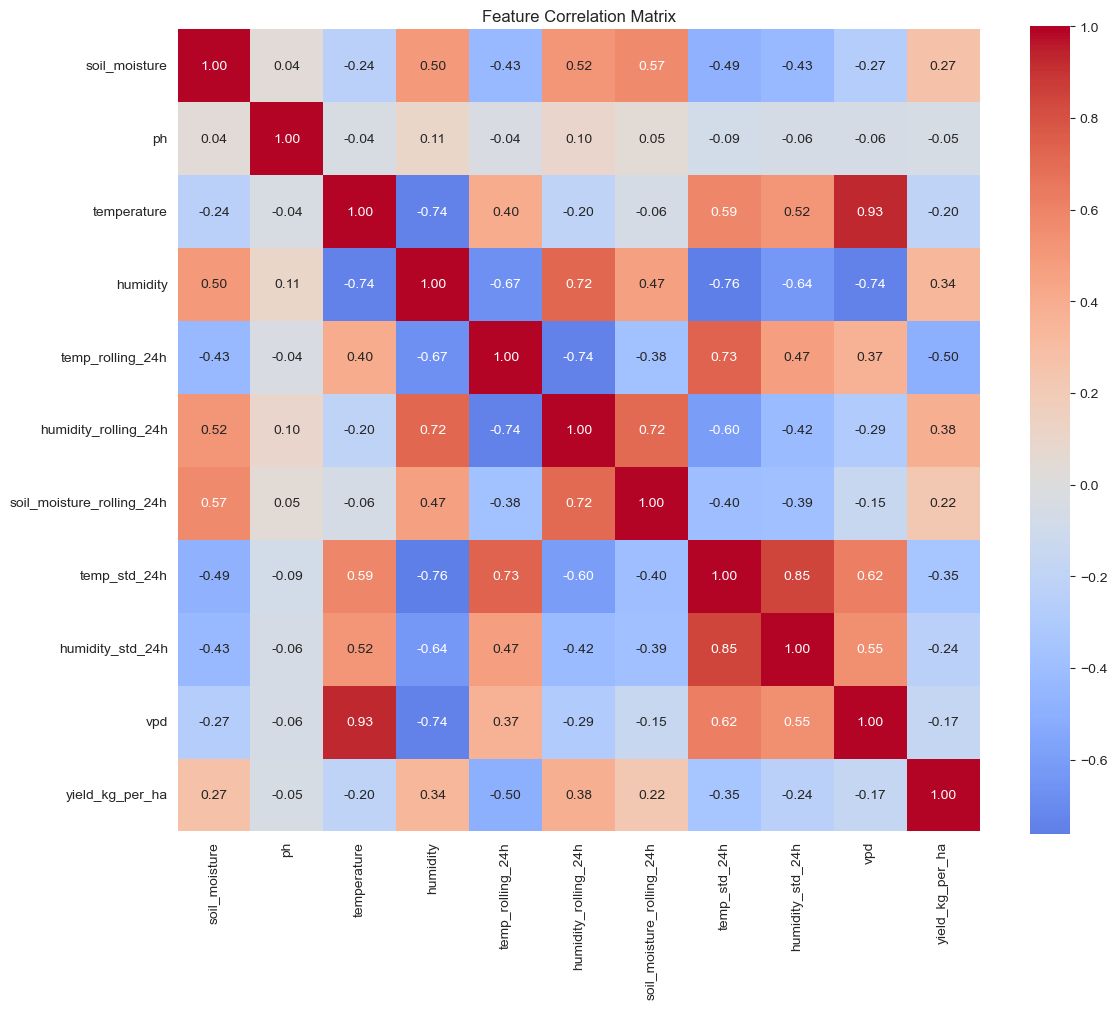


Correlation with Yield:
yield_kg_per_ha              1.000000
humidity_rolling_24h         0.382265
humidity                     0.341682
soil_moisture                0.265427
soil_moisture_rolling_24h    0.221911
ph                          -0.051779
vpd                         -0.168083
temperature                 -0.202472
humidity_std_24h            -0.235580
temp_std_24h                -0.345873
temp_rolling_24h            -0.500988
Name: yield_kg_per_ha, dtype: float64


In [11]:
# Select features for correlation analysis
correlation_features = [
    'soil_moisture', 'ph', 'temperature', 'humidity',
    'temp_rolling_24h', 'humidity_rolling_24h', 'soil_moisture_rolling_24h',
    'temp_std_24h', 'humidity_std_24h', 'vpd', 'yield_kg_per_ha'
]

corr_matrix = df_clean[correlation_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, square=True)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

print("\nCorrelation with Yield:")
print(corr_matrix['yield_kg_per_ha'].sort_values(ascending=False))

## 6. Prepare Training Data

In [12]:
# Select features for model training
feature_columns = [
    'soil_moisture', 'ph', 'temperature', 'humidity',
    'temp_rolling_24h', 'humidity_rolling_24h', 'soil_moisture_rolling_24h',
    'temp_std_24h', 'humidity_std_24h', 'vpd',
    'hour', 'day_of_week', 'day_of_year'
]

X = df_clean[feature_columns].copy()
y = df_clean['yield_kg_per_ha'].copy()

# Handle any remaining NaN values
X.fillna(X.median(), inplace=True)

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFeatures: {feature_columns}")

Feature matrix shape: (487, 13)
Target vector shape: (487,)

Features: ['soil_moisture', 'ph', 'temperature', 'humidity', 'temp_rolling_24h', 'humidity_rolling_24h', 'soil_moisture_rolling_24h', 'temp_std_24h', 'humidity_std_24h', 'vpd', 'hour', 'day_of_week', 'day_of_year']


In [13]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled using StandardScaler")

Training set size: 389
Test set size: 98

Features scaled using StandardScaler


## 7. Train Models

In [14]:
# Train Random Forest model
print("Training Random Forest model...")
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_rf_train = rf_model.predict(X_train_scaled)
y_pred_rf_test = rf_model.predict(X_test_scaled)

# Evaluate
print("\n=== Random Forest Results ===")
print(f"Training R² Score: {r2_score(y_train, y_pred_rf_train):.4f}")
print(f"Test R² Score: {r2_score(y_test, y_pred_rf_test):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf_test)):.2f} kg/ha")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred_rf_test):.2f} kg/ha")

Training Random Forest model...

=== Random Forest Results ===
Training R² Score: 0.8227
Test R² Score: 0.2749
Test RMSE: 256.76 kg/ha
Test MAE: 214.91 kg/ha


In [15]:
# Train Gradient Boosting model
print("Training Gradient Boosting model...")
gb_model = GradientBoostingRegressor(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
gb_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_gb_train = gb_model.predict(X_train_scaled)
y_pred_gb_test = gb_model.predict(X_test_scaled)

# Evaluate
print("\n=== Gradient Boosting Results ===")
print(f"Training R² Score: {r2_score(y_train, y_pred_gb_train):.4f}")
print(f"Test R² Score: {r2_score(y_test, y_pred_gb_test):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_gb_test)):.2f} kg/ha")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred_gb_test):.2f} kg/ha")

Training Gradient Boosting model...

=== Gradient Boosting Results ===
Training R² Score: 0.9999
Test R² Score: 0.0737
Test RMSE: 290.20 kg/ha
Test MAE: 239.44 kg/ha


## 8. Model Evaluation & Visualization

In [16]:
# Choose best model (using R² score)
rf_r2 = r2_score(y_test, y_pred_rf_test)
gb_r2 = r2_score(y_test, y_pred_gb_test)

if rf_r2 > gb_r2:
    best_model = rf_model
    best_model_name = "Random Forest"
    y_pred_test = y_pred_rf_test
    y_pred_train = y_pred_rf_train
else:
    best_model = gb_model
    best_model_name = "Gradient Boosting"
    y_pred_test = y_pred_gb_test
    y_pred_train = y_pred_gb_train

print(f"\nBest Model: {best_model_name}")


Best Model: Random Forest


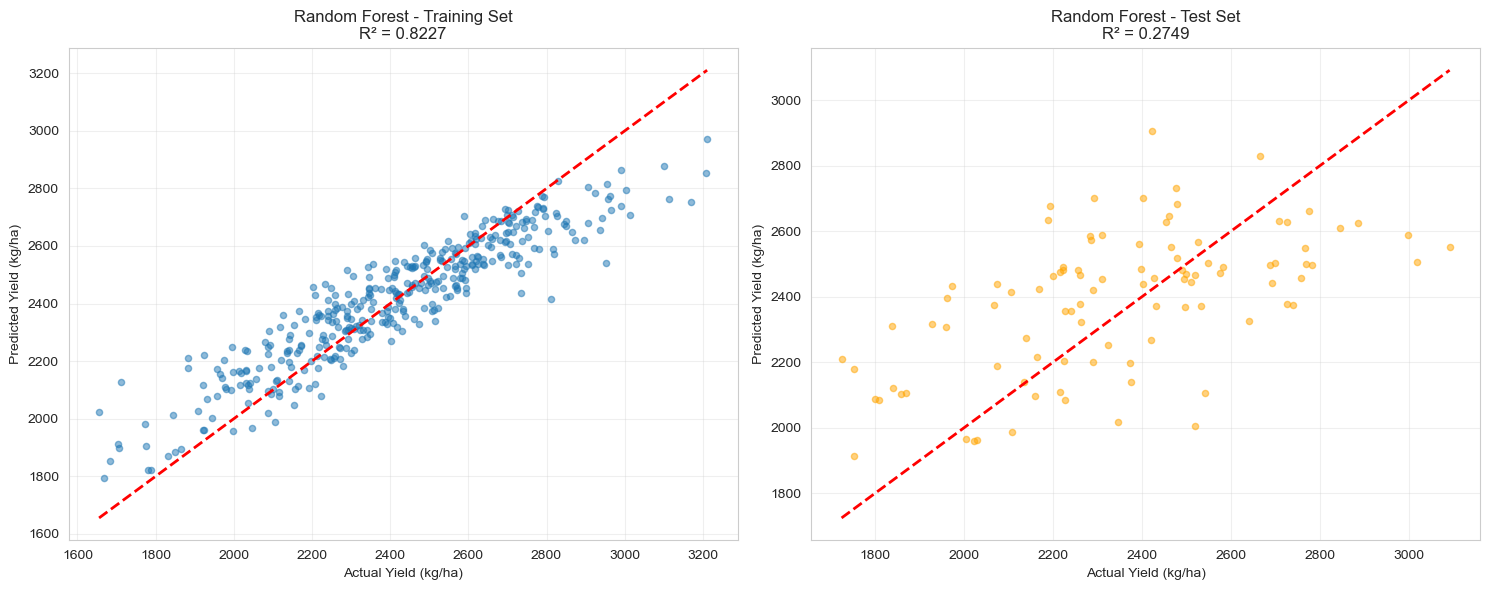

In [17]:
# Prediction vs Actual plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Training set
axes[0].scatter(y_train, y_pred_train, alpha=0.5, s=20)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Yield (kg/ha)')
axes[0].set_ylabel('Predicted Yield (kg/ha)')
axes[0].set_title(f'{best_model_name} - Training Set\nR² = {r2_score(y_train, y_pred_train):.4f}')
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].scatter(y_test, y_pred_test, alpha=0.5, s=20, color='orange')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Yield (kg/ha)')
axes[1].set_ylabel('Predicted Yield (kg/ha)')
axes[1].set_title(f'{best_model_name} - Test Set\nR² = {r2_score(y_test, y_pred_test):.4f}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

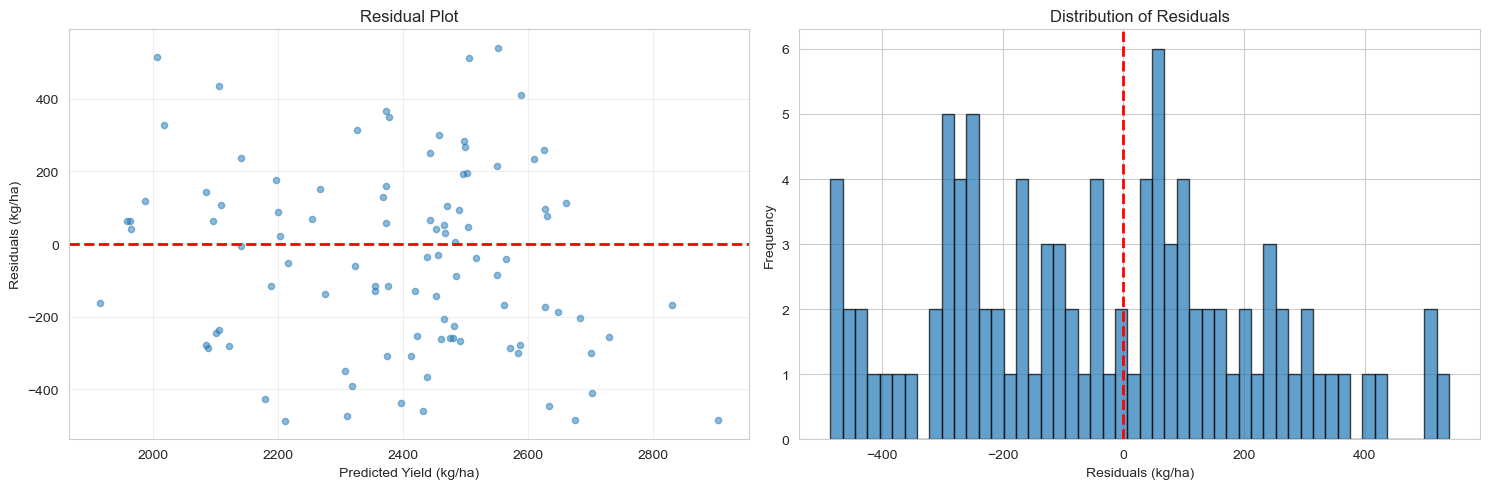

In [18]:
# Residual plot
residuals = y_test - y_pred_test

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Residuals vs Predicted
axes[0].scatter(y_pred_test, residuals, alpha=0.5, s=20)
axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Predicted Yield (kg/ha)')
axes[0].set_ylabel('Residuals (kg/ha)')
axes[0].set_title('Residual Plot')
axes[0].grid(True, alpha=0.3)

# Residual distribution
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Residuals (kg/ha)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Residuals')
axes[1].axvline(x=0, color='r', linestyle='--', lw=2)

plt.tight_layout()
plt.show()

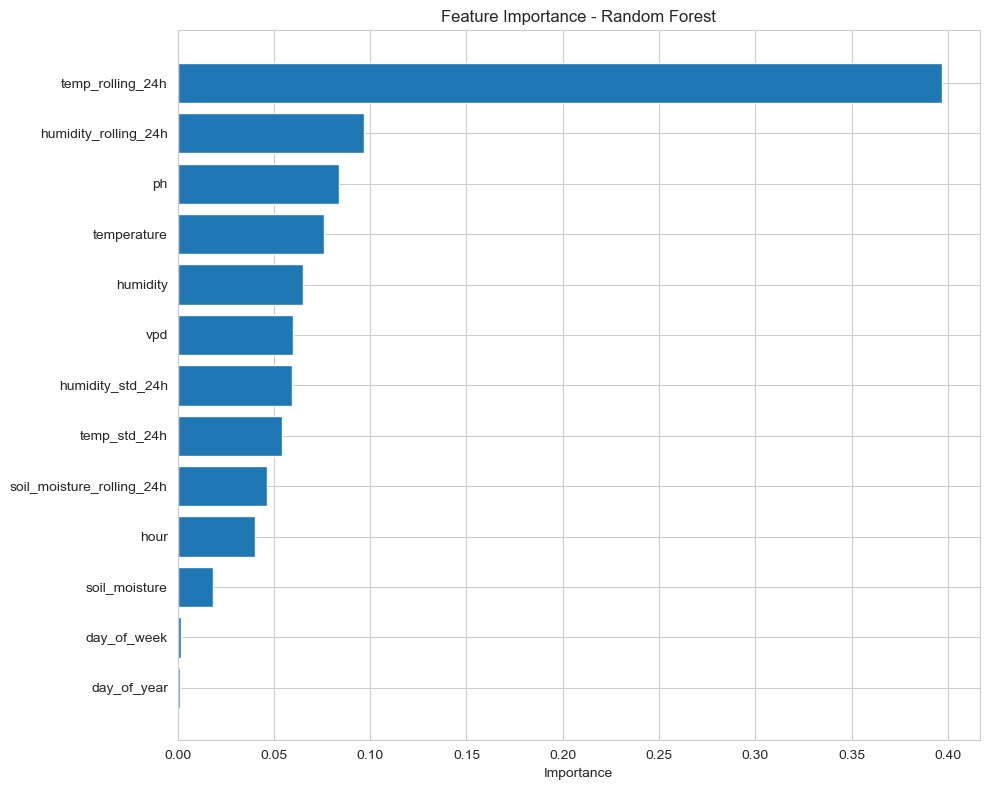


Top 5 Most Important Features:
                feature  importance
4      temp_rolling_24h    0.396787
5  humidity_rolling_24h    0.096750
1                    ph    0.083813
2           temperature    0.076193
3              humidity    0.065073


In [19]:
# Feature importance
if best_model_name == "Random Forest":
    importances = best_model.feature_importances_
else:
    importances = best_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Importance')
plt.title(f'Feature Importance - {best_model_name}')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 5 Most Important Features:")
print(feature_importance_df.head())

## 9. Save Model and Artifacts

In [20]:
# Create models directory if it doesn't exist
import os
os.makedirs('../backend/ml_pipeline/models', exist_ok=True)

# Save the best model
model_path = '../backend/ml_pipeline/models/yield_predictor.pkl'
joblib.dump(best_model, model_path)
print(f"Model saved to: {model_path}")

# Save the scaler
scaler_path = '../backend/ml_pipeline/models/yield_scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to: {scaler_path}")

# Save feature columns
feature_path = '../backend/ml_pipeline/models/yield_features.pkl'
joblib.dump(feature_columns, feature_path)
print(f"Feature list saved to: {feature_path}")

# Save model metadata
metadata = {
    'model_type': best_model_name,
    'training_date': datetime.now().isoformat(),
    'test_r2_score': float(r2_score(y_test, y_pred_test)),
    'test_rmse': float(np.sqrt(mean_squared_error(y_test, y_pred_test))),
    'test_mae': float(mean_absolute_error(y_test, y_pred_test)),
    'n_features': len(feature_columns),
    'training_samples': len(X_train),
    'test_samples': len(X_test)
}

import json
metadata_path = '../backend/ml_pipeline/models/yield_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"Metadata saved to: {metadata_path}")

print("\n=== Model Training Complete ===")
print(f"Model Type: {best_model_name}")
print(f"Test R² Score: {metadata['test_r2_score']:.4f}")
print(f"Test RMSE: {metadata['test_rmse']:.2f} kg/ha")
print(f"Test MAE: {metadata['test_mae']:.2f} kg/ha")

Model saved to: ../backend/ml_pipeline/models/yield_predictor.pkl
Scaler saved to: ../backend/ml_pipeline/models/yield_scaler.pkl
Feature list saved to: ../backend/ml_pipeline/models/yield_features.pkl
Metadata saved to: ../backend/ml_pipeline/models/yield_metadata.json

=== Model Training Complete ===
Model Type: Random Forest
Test R² Score: 0.2749
Test RMSE: 256.76 kg/ha
Test MAE: 214.91 kg/ha


## 10. Example Prediction

In [21]:
# Example prediction with optimal conditions
example_data = pd.DataFrame([{
    'soil_moisture': 70,
    'ph': 6.0,
    'temperature': 25.0,
    'humidity': 55.0,
    'temp_rolling_24h': 25.0,
    'humidity_rolling_24h': 55.0,
    'soil_moisture_rolling_24h': 70.0,
    'temp_std_24h': 2.0,
    'humidity_std_24h': 5.0,
    'vpd': 1.0,
    'hour': 12,
    'day_of_week': 3,
    'day_of_year': 150
}])

example_scaled = scaler.transform(example_data)
predicted_yield = best_model.predict(example_scaled)[0]

print("\n=== Example Prediction ===")
print("Input conditions (optimal):")
for col in example_data.columns:
    print(f"  {col}: {example_data[col].values[0]}")
print(f"\nPredicted Yield: {predicted_yield:.2f} kg/hectare")


=== Example Prediction ===
Input conditions (optimal):
  soil_moisture: 70
  ph: 6.0
  temperature: 25.0
  humidity: 55.0
  temp_rolling_24h: 25.0
  humidity_rolling_24h: 55.0
  soil_moisture_rolling_24h: 70.0
  temp_std_24h: 2.0
  humidity_std_24h: 5.0
  vpd: 1.0
  hour: 12
  day_of_week: 3
  day_of_year: 150

Predicted Yield: 2641.69 kg/hectare


## Next Steps

1. **Collect Actual Yield Data**: As you harvest, record actual yield per plot/sensor
2. **Retrain with Real Data**: Replace simulated yields with actual measurements
3. **Add More Features**: Consider adding:
   - Rainfall data
   - Soil nutrients (N, P, K)
   - Growth stage information
   - Pest/disease incidence
4. **Model Deployment**: Integrate predictions into the dashboard
5. **Continuous Improvement**: Retrain periodically as more data becomes available